In [23]:
import pandas as pd
from ase.visualize import view as view_molecule
from ase.io import read as read_molecule
import ase
import numpy as np
import random
import seaborn as sns

from ase.cell import Cell
from dscribe.descriptors import CoulombMatrix, SineMatrix, EwaldSumMatrix, MBTR

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy.linalg as LA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer

import catboost as cb
import shap
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error, r2_score


import warnings
warnings.filterwarnings('ignore')


In [6]:
DATA_PATH = '../nomad2018-predict-transparent-conductors'


In [7]:
def custom_converter(entry):
    return np.array([float(x) for x in entry[1:-1].split(',')])

In [8]:
train_all_data = pd.read_csv(
    f'{DATA_PATH}/train_extrainfo.csv',
    converters={
        'CoulombMatrix':custom_converter,
        'SineMatrix':custom_converter,
        'EwaldSumMatrix':custom_converter
    }
)
test_all_data = pd.read_csv(
    f'{DATA_PATH}/test_extrainfo.csv',
    converters={
        'CoulombMatrix':custom_converter,
        'SineMatrix':custom_converter,
        'EwaldSumMatrix':custom_converter
    }
)

In [9]:
train_all_data['CoulombMatrix'][0].shape

(6400,)

In [10]:
train_all_data.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev,CoulombMatrix,SineMatrix,EwaldSumMatrix
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387,"[121.10109815785134, 75.93020649243516, 122.09...","[1897.7459337097173, 175.12757587921956, 73.28...","[-147.16586613403337, -83.60940041075736, 50.8..."
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210,"[106.316346316413, 155.73823639588636, 139.218...","[1897.7459337097173, 155.40184168757955, 179.3...","[31.62494082794717, 499.7677140971106, 499.777..."
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438,"[76.85202206242872, 82.658215573199, 36.006484...","[1897.7459337097173, 64.86894200257981, 71.405...","[-105.23185191282306, -230.0887946397426, 9.15..."
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492,"[224.16370782409976, 216.10586898126473, 94.14...","[5694.30331076094, 475.2322348410168, 284.1925...","[-226.29548002634016, -767.1897774756807, -359..."
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793,"[161.3156894201164, 419.0476738666981, 161.311...","[5694.30331076094, 94.27325853815663, 195.3521...","[44.77486350842855, -804.0787210072267, -198.3..."


In [11]:
def get_vol(a, b, c, alpha, beta, gamma):
    return a*b*c*np.sqrt(1 + 2*np.cos(alpha)*np.cos(beta)*np.cos(gamma)
                           - np.cos(alpha)**2
                           - np.cos(beta)**2
                           - np.cos(gamma)**2)

# convert lattice angles from degrees to radians for volume calculation
lattice_angles = ['lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree']
for lang in lattice_angles:
    train_all_data[lang] = np.pi * train_all_data[lang] / 180

for lang in lattice_angles:
    test_all_data[lang] = np.pi * test_all_data[lang] / 180
    
# compute the cell volumes 
train_all_data['vol'] = get_vol(train_all_data['lattice_vector_1_ang'], train_all_data['lattice_vector_2_ang'], train_all_data['lattice_vector_3_ang'],
                          train_all_data['lattice_angle_alpha_degree'], train_all_data['lattice_angle_beta_degree'], train_all_data['lattice_angle_gamma_degree'])
        
test_all_data['vol'] = get_vol(test_all_data['lattice_vector_1_ang'], test_all_data['lattice_vector_2_ang'], test_all_data['lattice_vector_3_ang'],
                          test_all_data['lattice_angle_alpha_degree'], test_all_data['lattice_angle_beta_degree'], test_all_data['lattice_angle_gamma_degree'])

In [12]:
train_all_data['atomic_density'] = train_all_data['number_of_total_atoms'] / train_all_data['vol']   
test_all_data['atomic_density'] = test_all_data['number_of_total_atoms'] / test_all_data['vol']   

Text(0.5, 1.0, 'Features Correlating with Formation Energy')

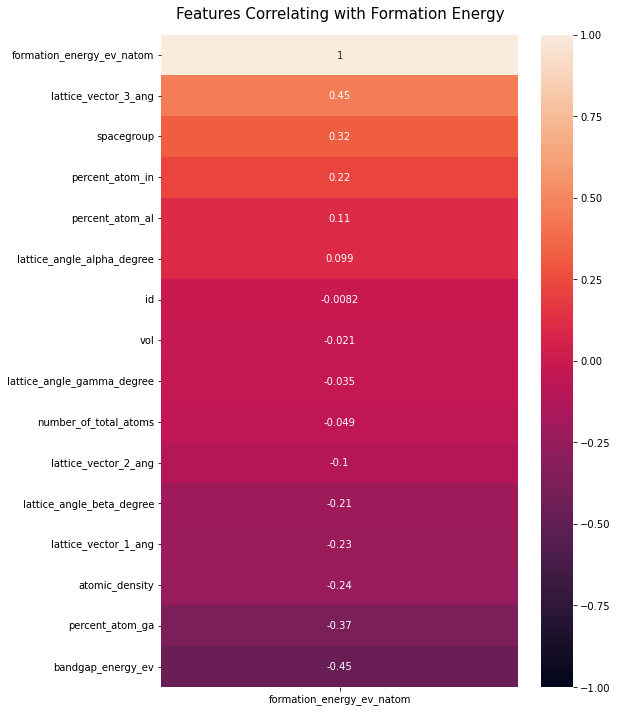

In [24]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train_all_data.corr()[['bandgap_energy_ev']].sort_values(by='bandgap_energy_ev', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with Bandgap Energy', fontdict={'fontsize':15}, pad=16)

# Basic linear regression

In [13]:
def get_eigenspectrum(matrix):
    spectrum = LA.eigvalsh(matrix)
    spectrum = np.sort(spectrum)[::-1]
    return spectrum

In [14]:
def create_matrix_df(data,pca_components=None,train=True, is_fe=True):
    ewald_spectrum_list = []
    for m in data['SineMatrix']:
        ewald_spectrum_list.append(
            get_eigenspectrum(
                np.reshape(m, (80, 80))
            )
        )
    ewald_spectrum_df = pd.DataFrame(ewald_spectrum_list).astype(float)
    ewald_spectrum_df = ewald_spectrum_df.fillna(0)
    x = ewald_spectrum_df.loc[:, :].values
    x = StandardScaler().fit_transform(x)
    #y = data.loc[:, ['formation_energy_ev_natom']].values
    pca = PCA(n_components=15).fit(x)

    # PCA n_components calculation
    rolling_sum = 0
    n_components = 1
    for i, num in enumerate(pca.explained_variance_ratio_):
        rolling_sum += num
        if rolling_sum > 0.95:
            n_components = i
            break
    
    if not train:
        n_components = pca_components

    n_components = 80
    # print(f'Performing PCA with {n_components} components')
    pca = PCA(n_components)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data=principalComponents)
    if train:
        if is_fe:
            to_drop = ['id', 'formation_energy_ev_natom',
                'CoulombMatrix', 'SineMatrix', 'EwaldSumMatrix', 'vol']
        else:
            to_drop = ['id', 'formation_energy_ev_natom', 'bandgap_energy_ev',
                'CoulombMatrix', 'SineMatrix', 'EwaldSumMatrix', 'vol']
        dfcombined = pd.concat([data, principalDf], axis=1).drop(to_drop, axis=1)
        #dfcombined = data.drop(to_drop, axis=1)
    else:
        to_drop = ['id',
               'CoulombMatrix', 'SineMatrix', 'EwaldSumMatrix', 'vol']
        dfcombined = pd.concat([data, principalDf], axis=1).drop(to_drop, axis=1)
        #dfcombined = data.drop(to_drop, axis=1)
    return dfcombined, n_components



In [15]:
def compute_final_values(train_all_data, test_all_data, target_column, model, is_fe_check):
    # train
    dfcombined, n_components = create_matrix_df(train_all_data, is_fe = is_fe_check)
    X_train, X_test, y_train, y_test = train_test_split(dfcombined, train_all_data[target_column], test_size = 0.30, random_state=1)
    rf = model.fit(X_train, y_train)
    score = rf.score(X_test, y_test)
    y_pred = rf.predict(X_test)

    print("Score:", score)
    print("Error rate:", ((mean_squared_error(y_test, y_pred)*100)), "%")
    
    # print(f'Training score for {target_column}: {score}')
    # test
    dfcombined, n_components = create_matrix_df(test_all_data, train=False, pca_components=n_components)
    predicted = rf.predict(dfcombined)
    return predicted


## Experiments

In [16]:
models = [
    ('randomforest', RandomForestRegressor(n_estimators=150, random_state=2), RandomForestRegressor(n_estimators=150, random_state=2)),
    ('ridge', Ridge(alpha=0.1), Ridge(alpha=0.1)),
    ('lasso', Lasso(alpha=0, max_iter=1e5), Lasso(alpha=0, max_iter=1e5)),
    ('linear regression', LinearRegression(),LinearRegression()),
    ('catboost', cb.CatBoostRegressor(loss_function='RMSE', depth=10, learning_rate=0.01), cb.CatBoostRegressor(loss_function='RMSE', depth=10, learning_rate=0.01)),
    ('xgboost', xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8), xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
)
    # ('svr', SVR(kernel = 'linear'), SVR(kernel = 'linear'))
]

In [17]:
print(train_all_data['bandgap_energy_ev'].corr(train_all_data['atomic_density']))
print(train_all_data['formation_energy_ev_natom'].corr(train_all_data['atomic_density']))

0.9129827545473875
-0.23837656031476862


In [18]:
train_all_data.columns

Index(['id', 'spacegroup', 'number_of_total_atoms', 'percent_atom_al',
       'percent_atom_ga', 'percent_atom_in', 'lattice_vector_1_ang',
       'lattice_vector_2_ang', 'lattice_vector_3_ang',
       'lattice_angle_alpha_degree', 'lattice_angle_beta_degree',
       'lattice_angle_gamma_degree', 'formation_energy_ev_natom',
       'bandgap_energy_ev', 'CoulombMatrix', 'SineMatrix', 'EwaldSumMatrix',
       'vol', 'atomic_density'],
      dtype='object')

In [21]:
for name, train_model, test_model in models:
    print(f'Running {name}')
    pred_bandgap = compute_final_values(
        train_all_data, 
        test_all_data, 
        target_column='bandgap_energy_ev',
        model = test_model,
        is_fe_check=False
    )

    for_fe_train = train_all_data
    for_fe_train = for_fe_train.drop('atomic_density', axis=1)
    for_fe_test = test_all_data
    for_fe_test = for_fe_test.drop('atomic_density', axis=1)
    for_fe_test['bandgap_energy_ev'] = pred_bandgap

    pred_fe = compute_final_values(
        for_fe_train, 
        for_fe_test, 
        target_column='formation_energy_ev_natom',
        model = train_model,
        is_fe_check=True
    )
    id_1 = np.arange(1, len(pred_fe)+1, 1, dtype=int)
    submission_df = pd.DataFrame({'id':id_1,'formation_energy_ev_natom':pred_fe,'bandgap_energy_ev':pred_bandgap})
    # submission_df.to_csv(f"./submissions/trial_submission_df_{name}.csv", index=False)
    

Running randomforest
Score: 0.9561944733010277
Error rate: 4.549101842710312 %
Score: 0.8790400815571459
Error rate: 0.12550333564802474 %
Running ridge
Score: 0.9464639360636874
Error rate: 5.559595454193004 %
Score: 0.8408865674822974
Error rate: 0.1650899470208619 %
Running lasso
Score: 0.9517649651053715
Error rate: 5.009095944222459 %
Score: 0.8398199115512689
Error rate: 0.16619666798311247 %
Running linear regression
Score: 0.9517430851195936
Error rate: 5.011368129746098 %
Score: 0.8400487410615467
Error rate: 0.16595924332869574 %
Running catboost
0:	learn: 0.9937244	total: 586ms	remaining: 9m 45s
1:	learn: 0.9867828	total: 1.01s	remaining: 8m 23s
2:	learn: 0.9797761	total: 1.47s	remaining: 8m 7s
3:	learn: 0.9727823	total: 1.9s	remaining: 7m 53s
4:	learn: 0.9659048	total: 2.33s	remaining: 7m 44s
5:	learn: 0.9600646	total: 2.72s	remaining: 7m 31s
6:	learn: 0.9538395	total: 3.11s	remaining: 7m 21s
7:	learn: 0.9472224	total: 3.5s	remaining: 7m 14s
8:	learn: 0.9403793	total: 3.9s	

### Code to save submission

In [ ]:
id_1 = np.arange(1, len(pred_fe)+1, 1, dtype=int)
submission_df = pd.DataFrame({'id':id_1,'formation_energy_ev_natom':pred_fe,'bandgap_energy_ev':pred_bandgap})
submission_df.head()


,id,formation_energy_ev_natom,bandgap_energy_ev
0,1,0.190195,1.574747
1,2,0.106253,3.382763
2,3,0.159420,3.264896
3,4,0.085424,2.818664
4,5,0.153552,1.610738


In [ ]:
submission_df.to_csv("submissions/trial_submission_df_3.csv", index=False)

In [ ]:
dfcombined_1, n_components_1 = create_matrix_df(train_all_data)

In [ ]:
dfcombined_1.head()

,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,...,70,71,72,73,74,75,76,77,78,79
0,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,...,-0.003700,-0.002907,0.004438,0.001137,0.001608,-0.012608,0.002607,-0.000743,-0.001971,-0.004777
1,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,...,0.000900,0.010686,-0.014056,-0.007346,0.003003,0.008881,0.006281,-0.009465,-0.005478,-0.005299
2,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,...,-0.000182,-0.001170,-0.001962,0.000589,-0.000964,-0.000659,0.000600,0.000013,-0.000809,0.000060
3,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,...,-0.000245,0.000454,-0.000142,0.001563,0.000906,0.000429,0.000110,0.000496,-0.000037,0.000061
4,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,...,0.003742,-0.026200,0.005514,-0.000055,-0.007035,-0.003736,-0.003962,0.004179,-0.011264,0.004670


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dfcombined_1, train_all_data['formation_energy_ev_natom'], test_size = 0.30, random_state=1)
rf_c2 = RandomForestRegressor(n_estimators=1000, random_state=2).fit(X_train, y_train)
y_pred = rf_c2.predict(X_test)
print("Error rate:", ((mean_squared_error(y_test, y_pred)*100)), "%")

Error rate: 0.13395129508282644 %


# Hyperparameter tuning

In [ ]:
dfcombined, n_components = create_matrix_df(train_all_data)
X_train, X_test, y_train, y_test = train_test_split(dfcombined, train_all_data['formation_energy_ev_natom'], test_size = 0.30, random_state=1)

rf_parameters = {
    'n_estimators':[50, 100, 150]
}
ridge_parameters = {
    'alpha':[0, 0.001, 0.1, 0.5, 1, 2, 10]
}
lasso_parameters = {
    'alpha':[0, 0.001, 0.1, 0.5, 1, 2, 10]
}
catboost_parameters = {
    'learning_rate':[0.01, 0.05, 0.1, 0.5],
    'depth':[4,6,10],
    # 'l2_leaf_reg':[1, 3, 5, 7, 9]
}



In [ ]:
# random forest
model = RandomForestRegressor()
rf_clf = GridSearchCV(model, rf_parameters)
rf_clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [50, 100, 150]})

In [ ]:
# ridge 
model = Ridge()
ridge_clf = GridSearchCV(model, ridge_parameters)
ridge_clf.fit(X_train, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [0, 0.001, 0.1, 0.5, 1, 2, 10]})

In [ ]:
# lasso
model = Lasso()
lasso_clf = GridSearchCV(model, lasso_parameters)
lasso_clf.fit(X_train, y_train)

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [0, 0.001, 0.1, 0.5, 1, 2, 10]})

In [ ]:
# catbooast
model = cb.CatBoostRegressor(task_type='GPU')
cb_clf = GridSearchCV(model, catboost_parameters)
cb_clf.fit(X_train, y_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already speci

CatBoostError: catboost/libs/train_lib/train_model.cpp:987: Can't load GPU learning library. Module was not compiled or driver  is incompatible with package. Please install latest NVDIA driver and check again

In [ ]:
print(f'Random forest: {rf_clf.best_params_}')
print(f'Lasso: {lasso_clf.best_params_}')
print(f'Ridge: {ridge_clf.best_params_}')
print(f'Catboost: {cb_clf.best_params_}')

Random forest: {'n_estimators': 150}
Lasso: {'alpha': 0}
Ridge: {'alpha': 0.1}
Catboost: {'depth': 10, 'learning_rate': 0.01}
